In [71]:
''' 
    Creation: 2021.09.12
    Last update: 2021.10.11

    User specific paths definition

'''
#Internal import 
import PVcharacterization_Utils as pv

data_folder = pv.assess_path_folders()
df_files_descp = pv.build_files_database(data_folder)

110 files was detected.
df_files_descp and the data base table PV_descp in C:\Users\franc\PVcharacterization_files\pv.db are built


In [72]:
''' Creation: 2021.09.19
    Last update: 2021.09.20
    
    df_meta dataframe building from selected files in database DATA_BASE_NAME
    
'''
import PVcharacterization_Utils as pv
df_meta = pv.build_metadata_dataframe(df_files_descp,data_folder)

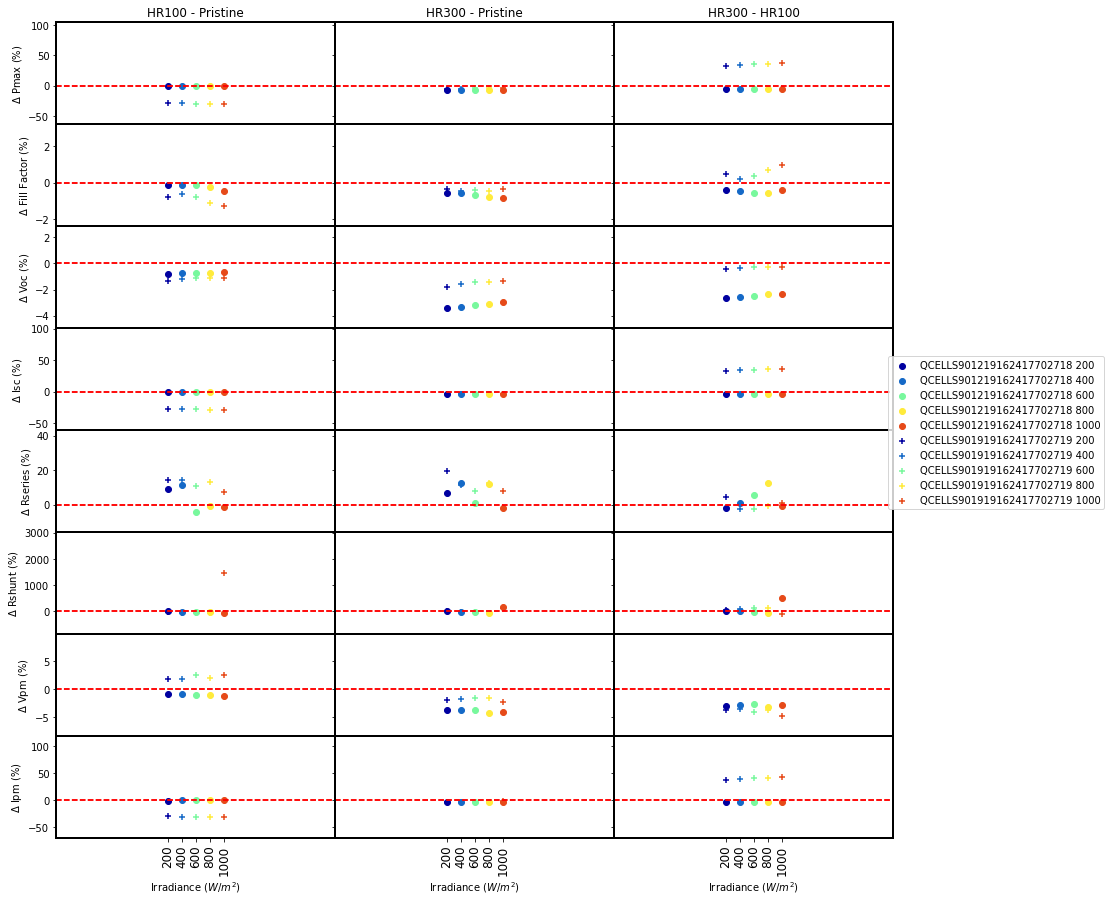

In [95]:
def input_treatment_labels(nbr_items): 
    
    import tkinter as tk
    global dict_label, n_items
    n_items= nbr_items
    root = tk.Tk()
    root.title("Python - Basic Register Form")
    
    FONT = ('arial', 18)
    FONT1 = ('arial', 20)

    width = 640
    height = 480
    screen_width = root.winfo_screenwidth()
    screen_height = root.winfo_screenheight()
    x = (screen_width/2) - (width/2)
    y = (screen_height/2) - (height/2)
    root.geometry("%dx%d+%d+%d" % (width, height, x, y))
    root.resizable(0, 0)

    def Register():
        global dict_label,n_items
        dict_label = {f'T{idx}': str(list_t[idx].get()) for idx in range(n_items)}

    TitleFrame = tk.Frame(root, height=100, width=640, bd=1, relief=tk.SOLID)
    TitleFrame.pack(side=tk.TOP)
    RegisterFrame = tk.Frame(root)
    RegisterFrame.pack(side=tk.TOP, pady=20)

    lbl_title = tk.Label(TitleFrame, text="PVcharacterization treatment labels", font=FONT, bd=1, width=640)
    lbl_title.pack()
    list_t = ['']*(n_items)
    for idx in range(n_items):
        list_t[idx] =  tk.StringVar()
        tk.Label(RegisterFrame, text= f'T{idx}:', font=FONT, bd=18).grid(row=1+idx)
        tk.Entry(RegisterFrame, font=FONT1, textvariable=list_t[idx], width=15).grid(row=1+idx, column=1)
    lbl_result = tk.Label(RegisterFrame, text="", font=FONT).grid(row=n_items+1, columnspan=2)
    

    btn_register = tk.Button(RegisterFrame, font=FONT1, text="Register", command=Register)
    btn_register.grid(row=n_items+2, columnspan=2)
    btn_exit = tk.Button(RegisterFrame, font=FONT1, text="EXIT", command=root.destroy)
    btn_exit.grid(row=n_items+3, columnspan=2)


    root.mainloop()
    return dict_label


def init_plot_diff(df_meta):
    
    # Standard library imports
    from itertools import combinations

    #3rd party imports
    import pandas as pd

    mod_selected = df_meta['module_type'].unique()
    if len(mod_selected)>2: raise Exception("Sorry, the number of modules must be <=2 ") 
    list_setup = []
    name =[]
    if len(mod_selected)==2:
        for x in df_meta[['module_type','treatment','irradiance']].groupby('module_type'):
            name.append(x[0] )
            list_setup.append(set(zip(x[1]['treatment'].tolist(), x[1]['irradiance'].tolist())))
        if list_setup[1] - list_setup[0]:
            raise Exception(f'Cannot compare {name[0] } and {name[1]}')

    list_treatments = pd.unique(df_meta['treatment'])

    if len(list_treatments)==1: raise Exception("Sorry, the number of treatments must be >1 ") 

    list_combinations = list(combinations(list_treatments,2))

    list_diff = pv.Select_items(list_combinations,
                                'Select the difference',
                                mode = 'multiple')
    list_diff = [(x[1],x[0]) for x in list_diff]

    return list_diff

def plot_params_diff(df_meta,list_diff, list_params=None,dic_trt_meaning=None):
    
    #Internal import 
    import PVcharacterization_Utils as pv
    
    #3rd party imports
    import pandas as pd

    list_allowed_params = list(pv.USED_COLS)
    list_allowed_params.remove('Title')
    if list_params is None:
        list_params = pv.Select_items(list_allowed_params,
                                      'Select the params',
                                       mode = 'multiple')
    else:
        params_copy = list(list_params)
        unkown_params = set(params_copy).difference(set( list_allowed_params))
        for unknow_param in unkown_params:
            print(f'WARNING parameter {unknow_param} will be ignored')
            list_params.remove(unknow_param)

    list_modules = pd.unique(df_meta['module_type'])          # List of modules name (ID)
    pv.plot_params(list_params,
                   list_modules,
                   df_meta,list_diff = list_diff,
                   dic_trt_meaning=dic_trt_meaning) #None

''' Creation: 2021.10.09
    Last update: 2021.10.09
    
    Interactive choice of the treatment differences
    
    ''' 

list_diff = init_plot_diff(df_meta)

#list_params = ['Pmax','Voc','Isc','Fill Factor','Rseries','bidon','trarmiz']
#list_diff = []
t = []
for x in list_diff:
   t.extend([x[0],x[1]])
nbr_items = len(set(t))
dic_trt_meaning = input_treatment_labels(nbr_items)
plot_params_diff(df_meta,list_diff,None,dic_trt_meaning)


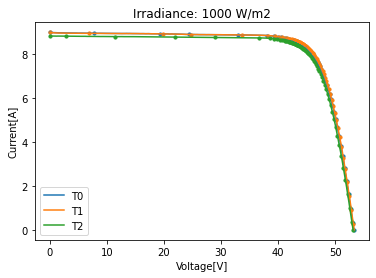

In [16]:
''' Creation: 2021.09.19
    Last update: 2021.09.20
    
    Plotting of I/V curves.
    
    '''

# Standard library imports
import os
from pathlib import Path

# 3rd party import
import matplotlib.pyplot as plt

#Internal import 
import PVcharacterization_Utils as pv

irr_select = [1000]
name_select = ["JINERGY3272023326035",]
trt_select = ["T0","T1","T2"]

database_path = Path(data_folder) / Path(pv.DATA_BASE_NAME)

querries = pv.sieve_files(irr_select,trt_select,name_select,database_path)

for i, res in enumerate([pv.data_parsing(querry).IV0 for querry in querries]):
    plt.plot(res['Voltage'],res['Current'],label=trt_select[i])
    plt.scatter(res['Voltage'][::50],res['Current'][::50],s=10)
    plt.xlabel(res.columns[0] +'[V]')
    plt.ylabel(res.columns[1] +'[A]')
    plt.title(f'Irradiance: {str(irr_select[0])} {pv.PARAM_UNIT_DIC["IrrCorr"]}')
    
plt.legend()
plt.show()

    